In [1]:
import torch
import torch.nn as nn

In [2]:
VAE_DIM = 3

In [3]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):

  def __init__(self, embed_dim=256, input_dim=VAE_DIM, hidden_dim=512):

    super().__init__()
    self.embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim),
        nn.SiLU(),
        nn.Linear(embed_dim, embed_dim)
    )
    
    self.lin1 = nn.Linear(input_dim, hidden_dim)
    self.dense1 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin2 = nn.Linear(hidden_dim, hidden_dim)
    self.dense2 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin3 = nn.Linear(hidden_dim, hidden_dim)
    self.dense3 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin4 = nn.Linear(hidden_dim, input_dim)
    
    self.act = nn.SiLU()
  
  def forward(self, x, t): 
    embed = self.act(self.embed(t))
    
    h = self.lin1(x)
    h += self.dense1(embed)
    h = self.act(h)
    
    h = self.lin2(h)
    h += self.dense2(embed)
    h = self.act(h)
    
    h = self.lin3(h)
    h += self.dense3(embed)
    h = self.act(h) 
    
    h = self.lin4(h)

    return h

In [4]:
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, args.latent_dim)
        self.fc22 = nn.Linear(400, args.latent_dim)
        self.fc3 = nn.Linear(args.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class VAE_DDPM(nn.Module):

    def __init__(self, vae_network: nn.Module, diff_network: nn.Module, T:int=100, beta_1:float=1e-4, beta_T:float=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model with VAE latent space.

        Parameters
        ----------
        vae_network: nn.Module
            nerual network for VAE encoder/decoder
        diff_network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(VAE_DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        self._diff_network = diff_network
        self.diff_network = lambda x, t: self._diff_network(x, t.squeeze()/T)

        self.vae_network = vae_network

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0:torch.Tensor, t:int, epsilon:torch.Tensor) -> torch.Tensor:
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt:torch.Tensor, t:int, epsilon:torch.Tensor) -> torch.Tensor:
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.diff_network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. (nsamples, VAE latent dim)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        xt_vae = self.vae_network.decode(xt)

        return xt_vae

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Encode input image into VAE latent space
        x0_vae, _ = self.vae_network.encode(x0.view(-1, 784))

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        # Sample noise
        epsilon = torch.randn_like(x0_vae)
        # Forward diffusion to obtain xt
        xt = self.forward_diffusion(x0_vae, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.diff_network(xt, t))
    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()

/home/arn/Documents/PML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
Training:  30%|██▉       | 3539/11800 [03:38<08:59, 15.30it/s, epoch=30/100, loss=0.1448, lr=7.02E-04]

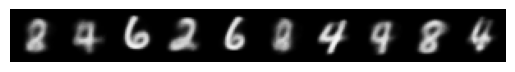

Training:  60%|█████▉    | 7079/11800 [07:22<04:38, 16.94it/s, epoch=60/100, loss=0.0679, lr=4.93E-04]

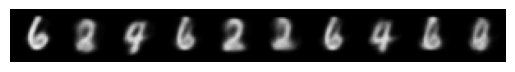

Training:  90%|████████▉ | 10619/11800 [11:00<01:08, 17.14it/s, epoch=90/100, loss=0.0689, lr=3.46E-04]

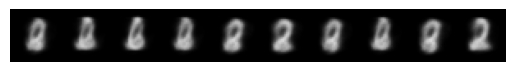

Training: 100%|██████████| 11800/11800 [12:12<00:00, 16.10it/s, epoch=100/100, loss=0.0858, lr=3.07E-04]


In [7]:
losses_list = []
timings_list = []

import time


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    start_train_time = time.time()

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        best_loss = float('inf')

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f" {loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()
            if loss.item() < best_loss:
                best_loss = loss.item()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            if epoch % 30 == 29:
                per_epoch_callback(ema_model.module if ema else model)
        
        losses_list.append(best_loss)
        timings_list.append(time.time() - start_train_time)

# Parameters
T = 500
learning_rate = 1e-3
epochs = 100
batch_size = 512


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

# Construct Score Network (MLP)
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
score_model = ScoreNet().to(device)
vae_network = torch.load("vae_mnist_model_b8_d3.pth", weights_only=False).to(device)

# Construct model
model = VAE_DDPM(vae_network, score_model, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples, VAE_DIM)).cpu()
        
        # VAE output is sigmoid 0..1, no need to remap
        # samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

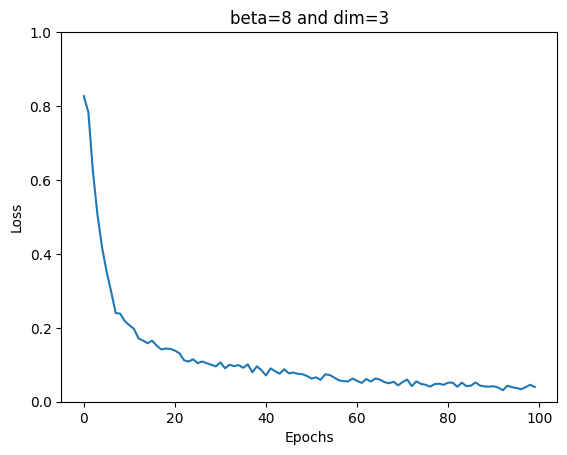

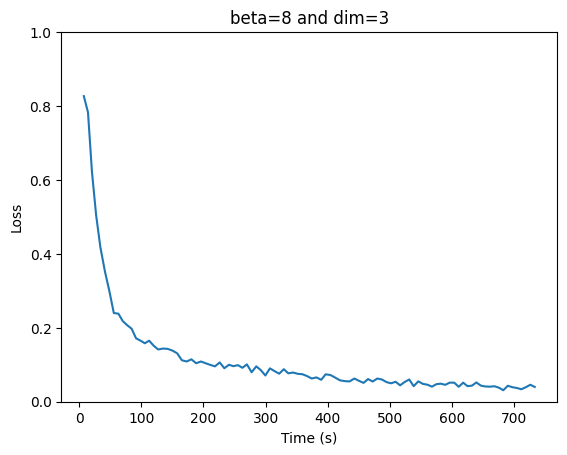

[0.8268746733665466, 0.7831563949584961, 0.6224260330200195, 0.5056800842285156, 0.41798409819602966, 0.3519864082336426, 0.297977089881897, 0.23999129235744476, 0.23824307322502136, 0.21801283955574036, 0.2069913148880005, 0.19732819497585297, 0.1715901643037796, 0.1654256284236908, 0.15818749368190765, 0.16510525345802307, 0.15184825658798218, 0.14141303300857544, 0.14385676383972168, 0.14299900829792023, 0.13831034302711487, 0.13102099299430847, 0.11208158731460571, 0.10884124040603638, 0.11473515629768372, 0.104144386947155, 0.10883121192455292, 0.10419006645679474, 0.09982681274414062, 0.09564312547445297, 0.1062590703368187, 0.09056968986988068, 0.10000013560056686, 0.09614082425832748, 0.09898128360509872, 0.09179791063070297, 0.10107433050870895, 0.07977254688739777, 0.09570510685443878, 0.08534764498472214, 0.07097829133272171, 0.09021306037902832, 0.08258801698684692, 0.0758010670542717, 0.08799239993095398, 0.07685300707817078, 0.07898649573326111, 0.0755460262298584, 0.0744

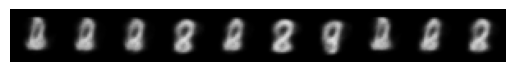

Lowest loss: 0.031086113303899765


In [8]:
# plot training losses
plt.plot(losses_list)
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,1)
plt.title("beta=8 and dim=3")
plt.show()

# Plot training loss over time
plt.plot(timings_list, losses_list)
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.ylim(0,1)
plt.title("beta=8 and dim=3")
plt.show()

print(losses_list)
print(timings_list)

# Sample final model
reporter(model)

# show lowest loss per
print(f"Lowest loss: {min(losses_list)}")


